In [1]:
import pickle
import torch
import random
import math
import torch.nn as nn
import numpy as np
from collections import namedtuple
from itertools import count
import matplotlib
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F
from Game import *

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

game = Game(sleep_time=.1, headless=False)
move_options = ['Left', 'Right', 'Up', 'Down']

In [2]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [3]:
# Define network

class DQN(nn.Module):
    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=4, padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=2, padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(16)

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size, padding=1, stride = 1):
            return (size  +2*padding - (kernel_size - 1) - 1) // stride  + 1
        
        convw = conv2d_size_out(conv2d_size_out(w, 4), 2)
        convh = conv2d_size_out(conv2d_size_out(h, 4), 2)
        linear_input_size = convw * convh * 16
        self.head = nn.Linear(linear_input_size, outputs)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))

        return self.head(x.view(x.size(0), -1))

In [4]:
def process_state(state):
    if state is not None:
        state = torch.tensor(state, dtype=torch.float)
        state = state.unsqueeze(0).unsqueeze(0)
    return state

# Check if a move is valid in a certain state
def isvalid(state, move):      
    cur_state = np.copy(state)

    if move == "Up":
        if is_row_combinable(cur_state.T):
            return True
        board_state = cur_state.T
    elif move == "Down":
        if is_row_combinable(cur_state.T):
            return True
        board_state = np.flip(cur_state.T, axis=1)
    elif move == "Left":
        if is_row_combinable(cur_state):
            return True
        board_state = cur_state     
    elif move == "Right":
        if is_row_combinable(cur_state):
            return True
        board_state = np.flip(cur_state, axis=1)
    else:
        print("Chosen Move is not an Option")
        return False
    
    num_zeros = count_zeros_left(board_state)
    result = num_zeros != 0
    return result

def is_row_combinable(cur_state):        
    # Loop over each row
    for row in cur_state:
        # Remove empty tiles
        row_collapsed = row[row != 0]

        # Check if row has combinable tiles
        if are_combinable(row_collapsed)[0]:
            return True


# Checks if there are any tiles that can
#  be combined given a list of tiles
# Returns a boolean and the biggest tile value that can be combined 
def are_combinable(row):
    row_collapsed = row[row != 0]
    # row_collapsed: list of tiles without empty spaces
    if len(row_collapsed) != 0:
        if len(set(row_collapsed)) < len(row_collapsed):
            # Find if there are duplicate tiles
            # adjacent to each other
            rolled_row = np.roll(row_collapsed,1)
            rolled_row[0] = 0
            diff = row_collapsed - rolled_row
            ndx_of_zero = np.where(diff == 0)
            collapsable_vals = rolled_row[ndx_of_zero]
            if (0 in row_collapsed - rolled_row):
                return True, max(collapsable_vals)

            # If there are no duplicate tiles adjacent to each other
            else: return False, None

        # If there are no duplicate tiles in the list
        else: return False, None

    # If there are no tiles in the list
    else: return False, None

# Given a state, counts the number of zeros
# to the left of each nonzero tile
def count_zeros_left(state):
    cur_sum = 0
    for row in state:                
        # Find position of nonzero tiles
        nonzero_ndx = np.nonzero(row)[0]

        # Sum the number of zeros to the left
        for n in nonzero_ndx:
            cur_sum += np.sum(row[:n] == 0)
    return cur_sum


In [5]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 8000
TARGET_UPDATE = 10

grid_width = 4
grid_height = 4
n_actions = 4

policy_net = DQN(grid_height, grid_width, n_actions)
target_net = DQN(grid_height, grid_width, n_actions)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            network_out = policy_net(process_state(state))
            ranked_actions = np.argsort(network_out.data.numpy()[0])
            chosen_action = ranked_actions[0]
            
            while not isvalid(state, move_options[chosen_action]):
                ranked_actions = ranked_actions[ranked_actions != chosen_action]
                chosen_action = ranked_actions[0]  
            
            return torch.tensor(chosen_action, dtype=torch.long).unsqueeze(0).unsqueeze(0)
            

    else:
        choices = np.array([0,1,2,3])
        rand_action = np.random.choice(choices)
        
        while not isvalid(state, move_options[rand_action]):
            choices = choices[choices != rand_action]
            rand_action = np.random.choice(choices)
            
        return torch.tensor(rand_action, dtype=torch.long).unsqueeze(0).unsqueeze(0)

episode_durations = []

def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    current_eps = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    plt.title('Training... Eps = {:.2f}'.format(current_eps))
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())
    
    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        display.clear_output(wait=True)
    
    plt.show()

In [6]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

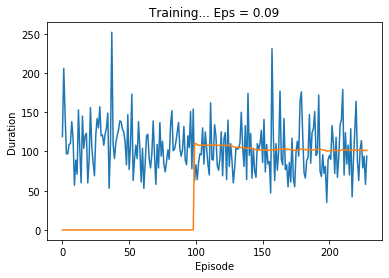

In [ ]:
num_episodes = 400

state = game.initial_state
for t in count():
    # Select and perform an action
    action = select_action(state)
    continue_playing, next_state, reward = game.move(move_options[action.item()], give_reward=True)
    reward = torch.tensor([reward])
    
    done = continue_playing == 'Game Over'
    if done:
        next_state = None

    # Store the transition in memory
    memory.push(process_state(state), action, process_state(next_state), reward)

    # Move to the next state
    state = next_state

    # Perform one step of the optimization (on the target network)
    optimize_model()
    if done:
        episode_durations.append(t + 1)
        plot_durations()
        break

for i_episode in range(num_episodes):
    # Initialize the environment and state
    game.reset()
    state = game.initial_state
    
    for t in count():
        # Select and perform an action
        action = select_action(state)
        continue_playing, next_state, reward = game.move(move_options[action.item()], give_reward=True)
        reward = torch.tensor([reward])

        done = continue_playing == 'Game Over'
        if done:
            next_state = None

        # Store the transition in memory
        memory.push(process_state(state), action, process_state(next_state), reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        optimize_model()
        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break
    
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())